In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score,accuracy_score
%matplotlib inline


In [2]:
combo_redd = pd.read_csv('../datasets/combo_redd.csv', index_col=0)

In [3]:
# Check for unbalanced classes.

combo_redd['target'].value_counts()

1    988
0    954
Name: target, dtype: int64

The classes are almost balanced.

### Split our data into `X` and `y`.

In [4]:
X = combo_redd['lemmatized']
y = combo_redd['target']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2,
                                                    stratify=y,
                                                    random_state = 42)

In [6]:
X_train.shape

(1553,)

In [7]:
y_train.shape

(1553,)

## Modeling

### Baseline Model

In [8]:
y_test.value_counts(normalize=True)

1    0.508997
0    0.491003
Name: target, dtype: float64

### Using Logistic Regression with GridSearchCV to model

In [9]:
#Set a pipeline up with two stages:
# 1. CountVectorizer (transformer)
# 2. LogisticRegression (estimator)

pipe_l = Pipeline([
    ('cvec_l', CountVectorizer()),
    ('lr', LogisticRegression(solver = 'lbfgs'))
])

In [10]:
# Search over the following values of hyperparameters:


pipe_params_l = {'lr__C': [0.001, 0.01, 0.1, 1],
              'lr__class_weight': [None, 'balanced'],
              'lr__penalty': ['l2'],
                'cvec_l__max_features': [2_000, 3_000, 4_000, 5_000],
                'cvec_l__min_df': [2, 3],
                'cvec_l__ngram_range': [(1,1), (1,2)]
}

In [11]:
# Instantiate GridSearchCV.

gs_l = GridSearchCV(pipe_l, # the object are we optimizing
                  param_grid=pipe_params_l, # the parameters values are we searching
                  cv=5) # 5-fold cross-validation.

In [12]:
# Fit GridSearch to training data.
gs_l.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('cvec_l',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        pr

In [13]:
# Save best model as gs_model.

model_l = gs_l.best_estimator_

In [14]:
# Score model on training set.
model_l.score(X_train, y_train)

0.9684481648422408

In [15]:
# Score model on testing set.
model_l.score(X_test, y_test)

0.8303341902313625

This model is overfitted as its accuracy score for the training data is higher than the test data and may not perform well on unseen data.

### Using Naive Bayes with GridSearchCV to model

In [16]:
nb = MultinomialNB()

In [17]:
# Set a pipeline up with two stages:
# 1. CountVectorizer (transformer)
# 2. LogisticRegression (estimator)

pipe_n = Pipeline([
    ('cvec_n', CountVectorizer()),
    ('nb', MultinomialNB())
])

In [18]:
# Search over the following values of hyperparameters:

pipe_params_n = {
                'cvec_n__max_features': [2_000, 3_000, 4_000, 5_000],
                'cvec_n__min_df': [2, 3],
                'cvec_n__max_df': [.9, .95],
                'cvec_n__ngram_range': [(1,1), (1,2)]
}

In [19]:
# Instantiate GridSearchCV.

gs_n = GridSearchCV(pipe_n, # the object are we optimizing
                  param_grid=pipe_params_n, # the parameters values are we searching
                  cv=5) # 5-fold cross-validation.

In [20]:
# Fit GridSearch to training data.
gs_n.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('cvec_n',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        pr

In [21]:
model_n = gs_n.best_estimator_

In [22]:
# Score model on training set.
model_n.score(X_train, y_train)

0.8660656793303284

In [23]:
# Score model on testing set.
model_n.score(X_test, y_test)

0.7737789203084833

Naive Bayes classifiers are classifiers which use probabilities for their classifications and are based on Bayes' Theorem. They assume that the features are independent from each other and are supposed to achieve high accuracy.

The model's performance on both training and testing data are similar, which should make this a good model for unseen data. However, the accuracy score on the testing data is less than the logistic regression model.

## Model Evaluation

Although the logistic regression model overfitted on the training data, it has the highest accuracy score and more accurate than the baseline model and hence used as the production model.

In [24]:
# Prediction of the test data
predictions = model_l.predict(X_test)


In [25]:
from sklearn.metrics import confusion_matrix

In [26]:
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()

In [27]:
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 161
False Positives: 30
False Negatives: 36
True Positives: 162


A true positive is an outcome where the model correctly predicts the positive class. Similarly, a true negative is an outcome where the model correctly predicts the negative class. 

A false positive is an outcome where the model incorrectly predicts the positive class. And a false negative is an outcome where the model incorrectly predicts the negative class.

As the number of true negatives is slightly higher than the number of true positives, the model is able to predict whether the post is about Sherlock or Elementary almost equally, with a slightly higher accuracy for Sherlock.

The higher false negatives indicates the model predicting more Sherlock posts wrongly than Elementary posts. This shows a slight bias to Sherlock posts and may be reflected in the specificity.

In [28]:
# The test specificity of the model

spec = tn / (tn + fp)

print(f'Specificity: {round(spec,4)}')

Specificity: 0.8429


In [29]:
# The test sensitivity of the model

sens = tp / (tp + fn)

print(f'Sensitivity: {round(sens,4)}')

Sensitivity: 0.8182


Sensitivity also known as the true positive rate indicates the proportion of true positives predicted out of the total positives.

Specficity also known as the true negative rate indicates the proportion of true negatives predicted out of the total negatives.

As expected from the confusion matrix, the specificity at 0.86 (rounded) is higher than the specificity 0.81(rounded), showing the model predicting a slightly higher accuracy for the negative class

### Distribution of probabilities

In [30]:
# Create a dataframe called pred_df that contains:
# 1. The list of true values of our test set.
# 2. The list of predicted probabilities based on our model.

pred_proba = [i[1] for i in model_l.predict_proba(X_test)]

pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})

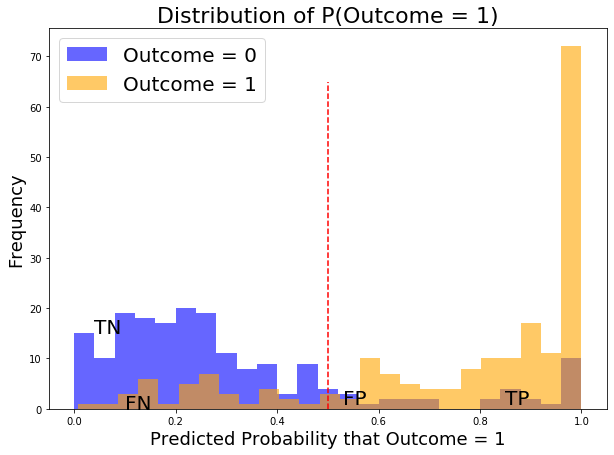

In [31]:
# Create figure.
plt.figure(figsize = (10,7))

# Create two histograms of observations.
plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
         bins = 25,
         color = 'b',
         alpha = 0.6,
         label = 'Outcome = 0')
plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
         bins = 25,
         color = 'orange',
         alpha = 0.6,
         label = 'Outcome = 1')

# Add vertical line at P(Outcome = 1) = 0.5.
plt.vlines(x = 0.5,
           ymin = 0,
           ymax = 65,
           color = 'r',
           linestyle = '--')

# Add annotations for TN, FN, TP, FP.
plt.annotate(xy = (0.04, 15),
             s = 'TN',
             size = 20)

plt.annotate(xy = (0.1, 0),
             s = 'FN',
             size = 20)

plt.annotate(xy = (0.85, 1),
             s = 'TP',
             size = 20)

plt.annotate(xy = (0.53, 1),
             s = 'FP',
             size = 20)

# Label axes.
plt.title('Distribution of P(Outcome = 1)', fontsize = 22)
plt.ylabel('Frequency', fontsize = 18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize = 18)

# Create legend.
plt.legend(fontsize = 20);

plt.savefig('../images/prob_dist.png')

The distribution of the predicted probilities of the negative and positive classes shows that the predicted possibilities of the positive class (orange) is more than the negative class (blue)
There is also quite a bit of overlap between both classes.

The threshold shown in the graph is 0.5 which seems an optimal balance to distinguish both the classes. The preference would be for the model to predict more of the positive class than negative class. However, some overlap is necessary to determine the similiarities between the 2 threads for the CBS executives' discovery of ways to be different from the other show.

In addition, there is a tradeoff between sensitivity and specificity if the threshold is to be moved.

One measure of how much overlap exists between our distributions is the area under the ROC curve.

### ROC AUC

In [32]:
roc_auc_score(pred_df['true_values'], pred_df['pred_probs'])


0.8606087048495425

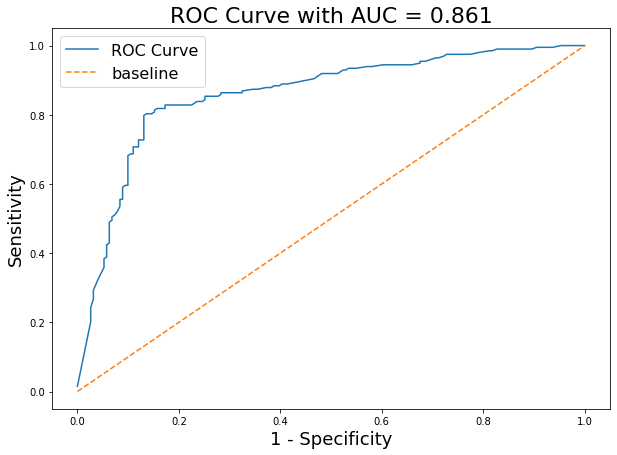

In [33]:
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values. (Dashed red line in image.)
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title(f'ROC Curve with AUC = {round(roc_auc_score(pred_df["true_values"], pred_df["pred_probs"]),3)}', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

plt.savefig('../images/roc.png')

The AUC - ROC curve or AUC (Area Under The Curve) ROC (Receiver Operating Characteristics) curve is used to visualize the model's performance is classification. The higher the score , the better the model is predicting the negative and positive class. 

The score of near to 1 or 1 indicates the model has almost perfect or perfect ability to classify between the 2 classes.

The score of 0.5, means model is unable to distinguish either class.

A score of zero means the model is classifying the positive class as the negative class and vice versa.

Our model has a score of 89 (rounded) indicates that it can distinguish between the 2 classes with some accuracy, which should be very good considering how the 2 shows are based on the same genre and same main characters.

### Reviewing why the posts were misclassified

In [34]:
# creating dataframe of predicted and actual results to compare
results=pd.DataFrame(predictions,columns=['predicted'], index = X_test.index) #indexing the results according to original index in X_test

#creating column for actual results
results['actual'] = y_test 

# creating dataframe of misclassified posts with results
row_ids = results[results['actual'] != results['predicted']].index # finding the indexes of misclassified posts

#creating dataframe of misclassified posts from X_test using their index
misclass =pd.DataFrame(X_test[row_ids]) 
misclass['pred'] = results['predicted'][row_ids] #creating column for the wrong predicted results

In [35]:
pd.set_option('display.max_colwidth', 200)

In [42]:
misclass.head(5)

,lemmatized,pred
546,factfilecan anyone find factfile need write full character report clue tip helpful thanks,1
1071,community activityso mod anything want gauge interest sub rewatch absolutely love played huge part life pretty inactive sub okay enough interest would like group sunday night site like rabbit disc...,0
128,anyone know discombobulated film used bbc sure cant find soundtrack,1
726,little sneak peek big meta writing put inside another huge meta s4basically analysis s4 stumble dialogue think enough get post posting mainly really proud bit really like whole concept got exited ...,1
1349,chicken,0


In [37]:
misclass.shape

(66, 2)

The model misclassified 65 posts. Reading the posts, it is understandable the posts can be misclassified as some posts lack sufficient amount of text or any relevant words to classify the posts accurately. However, it is interesting to see post no.508 being classified as an Elementary post when the word 'john', a character from Sherlock, is mentioned several times.  

### Get top impactful words

In [38]:
#Getting the words used in modeling
feature= model_l.steps[0][1].get_feature_names()


In [39]:
# mapping coefficients and their corresponding words into a mainframe
coefficients =pd.DataFrame(model_l.named_steps['lr'].coef_.T, index = feature, columns=['coef'])

In [40]:
# Sorting into the top 20 coefficients and their words
coefficient_20 = (coefficients.sort_values('coef', ascending=False))['coef'][:20]

In [41]:
coefficient_20

joan          2.029170
promo         1.842511
finale        1.489501
cbs           1.456896
renewed       1.433557
anyone        1.366018
return        1.249385
lucy          1.176168
hulu          1.148565
kitty         1.148551
miss          1.121215
sneak         1.097638
clyde         1.086568
discussion    1.058996
wear          1.052680
10            1.017161
actor         1.006725
bad           0.985270
gregson       0.974341
started       0.944931
Name: coef, dtype: float64

The top 20 words that help the model classify Elementary posts make sense as 'joan' is one of the main characters and ' 'kitty','bell', 'gregson', 'anyone' are names of recurring characters in the show. 

The word 'lucy' is interesting as it refers to the actress Lucy Liu who plays Joan Watson. No other actors/actresses name is in the top 20 including the actor who plays Sherlock, the main character. This may indicate that viewers find her and her character more interesting than any other actor/character in the show.

The word 'clyde' amusingly appears in the top 20 as it is the name of Sherlock's pet tortoise.

The term 's6' may show that viewers consider that episodes from that season more interesting than other seasons including the final season 7.

The term 'finale' in top 20 may be unsurprising as any last episode of a show should bear some discussion.

## Conclusion

The classification model using Logistic Regression has shown that the 2 shows can be distinguished from one another as it has an accuracy score of 0.89 (rounded) higher than the baseline model. This is surprising as the other classifiers used, a Naive Bayes classifier, are known to for their high accuracy.

Our model has a ROC AUC score of 89 (rounded) indicates that it can distinguish between the 2 classes with some accuracy, which is great considering how the 2 shows are based on the same genre and same main characters.

However, the model has a slight bias towards the negative class i.e r/sherlock posts. 

The posts that the model misclassified had words that do not relate to either subreddits and hence not surprisingly our model was unable to classify them. However, there was one post that had the word 'john' numerous times yet the model still misclassified it, indicating our model still needs more adjustment to be a better classifier.

Hence CBS executives should be reassured that viewers are able to distinguish between both the shows as the model is able to classify the subreddits based the viewers' discussions of the shows. In addition, the model is also able to identify words that strongly relate to the show Elementary i.e the names of main and recurring characters. 

## Recommendation

CBS executives should explore ideas on strengthening the character development on their recurring characters. Even though some the most recurring charter names were in the top 20 impactful words, the top 20 most frequent words in the EDA showed that 'eurus'( the name of Sherlock's sister, who is not the most frequent recurring charter). Indicating that viewers felt that the character was more interesting than the recurring other characters.

CBS executives could also explore further development of the character 'joan' as both the name of the character and actress appeared in the top 20 impactful words. The executives can also consider giving more screentime to 'clyde' since he also appeared in the top 20 impactful words indicating that viewers like to discuss him.

The word 's6' appears in the top 25 impactful words, which may mean that viewers found season 6 of the show interesting than the final season 7. This is further evidenced since the posts scrapped are the newer posts and season 7 and related reference to it was not in the top 25 impactful words.

To improve the model, more data such as episode transcripts can be given.  Other classifiers such as Support Vector Machines or Random Forest Classifiers can be used. Different transformers like TfidfVectorizer Different hyperparameters can be used such as increasing the range of ngrams. Reduce the number of features to reduce the noise.

A sentiment analysis can also be performed on the subreddits to help assure executives whether viewers prefer Elementary more than Sherlock.

## Considerations

The model is based on data from the most recent subreddit posts and hence may not be able to classify earlier posts as they discuss the earlier seasons and hence the impactful words may be different. 

The words used in both subreddits may be culturally different as Sherlock was made by the BBC, a British show and hence attract viewers who are mostly British who would discuss using British vernacular while ELementary is from an American company and their viewers might be mostly American using American vernacular.
The model may be distinguishing the subreddits based on the different vernacular instead of the content of the shows.

## References:
    
https://analyticstraining.com/sensitivity-vs-specificity-in-logistic-regression/ 

https://en.wikipedia.org/wiki/Naive_Bayes_classifier

https://developers.google.com/machine-learning/crash-course/classification/true-false-positive-negative

https://en.wikipedia.org/wiki/Sherlock_(TV_series)

https://en.wikipedia.org/wiki/Elementary_(TV_series)

https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5